## Variational approximations

Bobak Shahriari

### Preface

Seeing as the next reading group meets tomorrow, I thought I'd pass this around so that people could play around with stuff we discussed about last week. Unforunately, this notebook isn't as detailed as I want yet but hopefully some of you will find it useful.

March 8, 2016

### Setting

In order to gain intuitions about variational approximations and Laplace approximations, I'll use the simplest possible example I can think of, namely fitting a one-dimensional Gaussian mixture model (GMM) with a single Gaussian. Let's call $P$ the target GMM and $Q$ the normal approximating distribution:

$P = \rho_1 \mathcal{N}(\mu_1, \sigma_1^2) + \rho_2 \mathcal{N}(\mu_2, \sigma_2^2)$, and

$Q = \mathcal{N}(\mu, \sigma^2)$,

were $\rho_1 + \rho_2 = 1$.

In the next four cells, I will:

* implement a bare-bones GMM;
* implement the KL divergence between a normal and a target $P$;
* define a function to find the KL-minimizing normal distribution $Q_{kl}$; and
* define a function to find the Laplace approximation $Q_{la}$.

In the last cell I run a little experiment: **more details below**.

In [1]:
%pylab inline --no-import-all
from matplotlib import rc
rc('lines', linewidth=2)
import numpy as np
import scipy.misc
import scipy.optimize as spopt
import scipy.stats as ss


class GMM:
    """Implements a simple Gaussian mixture model."""
    
    def __init__(self, rho, mu, sig):
        """
        Initializes a GMM with three arrays of same size:
            rho: probability of each Gaussian in mixture, must sum to 1;
            mu: location of each Gaussian mode; and
            sig: width of each Gaussian mode (std dev).
        """
        self.rho = rho
        self.mu = mu
        self.sig = sig
        
    def logpdf(self, x):
        terms = [np.log(r) + ss.norm.logpdf(x, loc=m, scale=s)
                 for r, m, s in zip(self.rho, self.mu, self.sig)]
        logpdf = scipy.misc.logsumexp(terms, axis=0)
        return logpdf
    
    def pdf(self, x):
        return np.exp(self.logpdf(x))
    
    def get_moments(self):
        """
        Returns the moments of the GMM distribution.
        (Strictly speaking, the mean and std dev.)
        """
        mean = np.dot(self.rho, self.mu)
        mom2 = np.dot(self.rho, self.mu ** 2 + self.sig ** 2)
        var = mom2 - mean**2
        return mean, np.sqrt(var)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def KL(Q, P, grad=False):
    """
    KL divergence between Q (normal) and P, the latter must have a
    `self.logpdf()` method.
    If Q is a list or tuple, the first and second element are assumed
    to be the mean and std dev of the normal Q.
    """
    uu = np.linspace(-5, 5, 1e3)   # integration grid (accurate enough for our purposes)
    du = uu[1] - uu[0]
    
    if isinstance(Q, (tuple, list, np.ndarray)):
        mu, sig = Q[0], Q[1]
    else:
        mu, sig = Q.mean(), Q.std()
    
    Qpdf = ss.norm.pdf(uu)
    Plogpdf = P.logpdf(mu + sig * uu)
    
    entropy = ss.norm.entropy(loc=mu, scale=sig)    # usually easy, by choice of Q
    energy = np.trapz(Qpdf * Plogpdf, dx=du)        # difficult in general
    
    # simple quadrature
    kl = -entropy - energy
    
    if not grad:
        return kl
    
    # the following integrations will be difficult in general
    integrand_dmu = uu * Qpdf * Plogpdf
    integrand_dsig = (uu**2 - 1.) * Qpdf * Plogpdf
    
    dkl_dmu = np.trapz(integrand_dmu, dx=du)
    dkl_dmu /= -sig
    dkl_dsig = 1 + np.trapz(integrand_dsig, dx=du)
    dkl_dsig /= -sig
    # concatenate the gradient
    dkl = np.array([dkl_dmu,
                    dkl_dsig])
    
    return kl, dkl

In [ ]:
def min_kl_normal(P, maxrestarts=10):
    """
    Return the normal distribution with the minimum KL divergence
    with respect to the target distribution P.
    """
    def _kl(theta):
        """Simple wrapper around `KL()` to request gradient."""
        return KL(theta, P, grad=True)
    
    bounds = [[-2.0, 2.0],     # bounds for mean...
              [1e-2, 2.0]]     # ... and std dev
    
    # simple multi-restart L-BFGS-B
    kl_min = np.inf
    
    for i in xrange(maxrestarts):
        mu0 = np.random.uniform(-1.0, 1.0)      # initial guesses
        sig0 = np.random.uniform(1e-1, 1.0)

        info = spopt.minimize(_kl, [mu0, sig0], jac=True, bounds=bounds)
        
        if info.success and (info.fun < kl_min):
            mu, sig = info.x
            kl_min = info.fun

    if np.isinf(kl_min):
        raise RuntimeError, info.message
    
    return ss.norm(loc=mu, scale=sig)

In [3]:
def laplace_approx(P, maxrestarts=10):
    """
    Return the normal distribution given by the Laplace approximation
    targetting the distribution P.
    """
    def _neglogpdf(x):
        """Simple wrapper to negate `P.logpdf()`."""
        return -P.logpdf(x)
    
    # simple multi-restart L-BFGS
    nlp_min = np.inf
    
    for i in xrange(maxrestarts):
        mu0 = np.random.uniform(-1, 1)     # initial guess
    
        # find max of target density
        info = spopt.minimize(_neglogpdf, mu0)
        
        if info.success and (info.fun < nlp_min):
            mu = info.x
            nlp_min = info.fun
    
    if np.isinf(nlp_min):
        raise RuntimeError, info.message

    # finite difference approx to the second derivative at the max
    dx = 1e-2
    sig = _neglogpdf(mu + dx) - 2 * _neglogpdf(mu) + _neglogpdf(mu - dx)
    sig = dx / np.sqrt(sig)
    
    return ss.norm(loc=mu, scale=sig)

### The last cell

Running the next cell should produce two columns of plots. It may take a few moments as I didn't do too much optimizing of the code.

Fixing $\rho_i$ and $\mu_i$, I'll simply shrink the identical widths $\sigma_i$ of the two target Gaussian modes of $P$. In doing so, a gap is created between the two. Notice how $Q_kl$ goes from trying to summarize the entire distribution $P$ to locking onto a single mode in the last row.

_NB: Thanks to a multi-restart optimization strategy $Q_{kl}$ and $Q_{la}$ often lock onto the tallest mode, but with more modes and in higher dimensions, this will be more challenging._

On the right hand column, contour plots show the KL divergence in parameter space $(\mu, \sigma)$ and markers locate the various approximations. These reveal the evolution of the KL surface as $\sigma_i$ is shrunk. The landscape gradually goes from having a single global optima to three local optima.

### Asymmetry in KL

Recall that the KL divergence is asymmetric in its arguments.
Hopefully, there are more details to come soon but in this case, but minimizing the KL divergence in the other direction simply corresponds to matching the first and second moments to $P$; I'll call that distribution $Q_{mm}$.

By comparing $Q_{kl}$ and $Q_{mm}$, we can see the phenomenon we alluded to in last week's discussion, namely the fact that the former wants its support to be dominated by $P$, while the latter wants be dominate $P$.

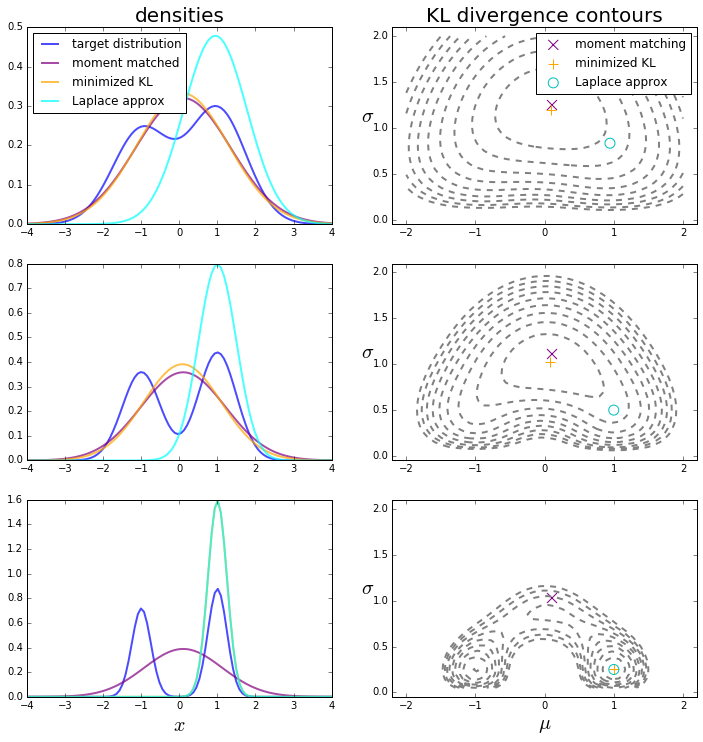

In [6]:
# fix random seed for reproducibility
np.random.seed(0)

# grid size in 1D and 2D
ngrid1 = 100
ngrid2 = 40

# build some grids for plotting
xx = np.linspace(-4, 4, ngrid1)
means = np.linspace(-2, 2, ngrid2)
variances = np.linspace(0.05, 2, ngrid2)
grid = np.meshgrid(means, variances)
grid = np.vstack((g.flatten() for g in grid)).T

# fixed parameters of the GMM
rhos = np.array([0.45, 0.55])
mus = np.array([-1, 1])

# varying parameters of the GMM
sigmas = np.arange(0.75, 0.24, -0.25)
sigmas = np.vstack((sigmas, sigmas)).T

fig, axs = plt.subplots(len(sigmas), 2, figsize=(12,4*len(sigmas)))

for i in xrange(len(sigmas)):
    sigs = sigmas[i]
    P = GMM(rhos, mus, sigs)
    
    mu_mm, sig_mm = P.get_moments()
    Q_mm = ss.norm(loc=mu_mm, scale=sig_mm)
    Q_kl = min_kl_normal(P)
    Q_la = laplace_approx(P)
    
    # plot densities
    axs[i,0].plot(xx, P.pdf(xx), label='target distribution',
                  color='blue', alpha=0.7);
    axs[i,0].plot(xx, Q_mm.pdf(xx), label='moment matched',
                  color='purple', alpha=0.7);
    axs[i,0].plot(xx, Q_kl.pdf(xx), label='minimized KL',
                  color='orange', alpha=0.7);
    axs[i,0].plot(xx, Q_la.pdf(xx), label='Laplace approx',
                  color='cyan', alpha=0.7);

    # plot KL divergence...
    KLP = lambda theta: KL(theta, P)
    surf = np.apply_along_axis(KLP, 1, grid).reshape((ngrid2, ngrid2))
    
    kl_min = surf.min()
    clevels = np.linspace(kl_min, 2. + kl_min, 10, endpoint=True)    # contour levels
    axs[i,1].contour(means, variances, surf, clevels, colors='gray', linestyles='--')
    
    # ...and solutions in parameter space
    axs[i,1].scatter(Q_mm.mean(), Q_mm.std(), 100, label='moment matching',
                     marker='x', color='purple')
    axs[i,1].scatter(Q_kl.mean(), Q_kl.std(), 100, label='minimized KL',
                     marker='+', color='orange')
    axs[i,1].scatter(Q_la.mean(), Q_la.std(), 100, label='Laplace approx',
                     marker='o', color='c', facecolor='none')
    axs[i,1].set_ylabel('$\sigma$', fontsize=20, rotation=0)
    
    if not (i % 4):
        axs[i,0].legend(loc=0);
        axs[i,1].legend(loc=0, scatterpoints=1);

# a bit of decorating...
axs[-1,0].set_xlabel('$x$', fontsize=20);
axs[-1,1].set_xlabel('$\mu$', fontsize=20);
axs[0,0].set_title('densities', fontsize=20);
axs[0,1].set_title('KL divergence contours', fontsize=20);